# Locality-Sensitive Hashing and Functions

Prepared by: Norbert Paul R. Gerena

In [2]:
import matplotlib.pyplot as plt
import numpy as np

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-kueo5cc8 because the default path (/home/ngerena/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Flow of Discussion

1. Introduction and Motivation to LSH
2. Review of hashing and MinHash Signature Matrix
3. LSH for Jaccard Distance
4. Generalizing LSH
6. Putting it all together
5. Applications

## I. Introduction

In this notebook, we will be discussing Locality-Sensitive Hashing (LSH) and its applications.

Why locality?

Why not compute it as needed?

Why use hashing?

Note: The structure and contents of this notebook is mainly based on the first reference [1].

## II. Review of Hashing and MinHash Signature Matrix

Hashing in the context of LSH

Shorter signature means we can fit it to memory
Jaccard Sim (shingles) $\approx$ Hamming Sim (Sigs)

## III. LSH for Jaccard Distance (Using the MinHash Signature Matrix) 

**General Idea:** For a huge set of elements, we do not want to evaluate the similarity of every pair of elements. Our goal for LSH is to generate from these collection of elements, a small list of potentially similar pairs or candidate pairs. We can then evaluate the similarity of these candidate pairs.

**We can generate candidate pairs directly from the MinHash signature**

Even if the MinHash signature matrix has significantly lower rows, we still need to evaluate $num. sets \choose 2$ pairs.

### LSH for MinHash Signature Matrix

1. Divide the signature matrix $M$ into $b$ bands and $r$ rows per band.

![](images/lsh1.png)

2. Per band, apply a hash function. We can use the same hash function for all bands but each band must have its own hash table.

![](images/lsh2.png)

3. Candidate column pairs are those that hash to the same bucket for $\ge$ 1 band

**Let's look at the math of the LSH function described above**

1. Let's assume that columns $C_1$ and $C_2$ have similarity $s$.
2. The probability that row n of $C_1$ and row n of $C_2$ are equal is approximately $s$, since we are dealing with the MinHash Signature.
3. Within a band, the probability that all rows are equal is $s^r$. Conversely, the probability that some rows are not equal is $1-s^r$.
4. The probability that not bands are identical is $(1-s^r)^b$
5. Finally, the probability that at least 1 band is identical is $1-(1-s^r)^b$

Let's look at the characteristics of this function.

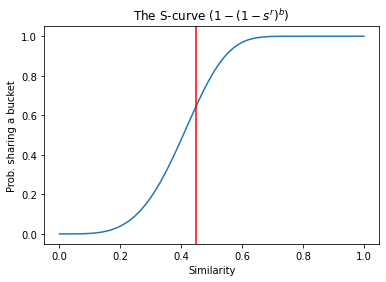

In [3]:
#relationship of r and b to the s-curve
r = 4
b = 25

def sfunc(x, r, b):
    return 1 - (1-x**r)**b

xs = np.arange(0,1.01, 0.01)
ys = list(map(lambda x: sfunc(x, r, b), xs))
plt.plot(xs, ys)
plt.title('The S-curve ($1-(1-s^r)^b$)');
plt.xlabel('Similarity')
plt.ylabel('Prob. sharing a bucket')

t = (1/b)**(1/r) #the treshold depends on b and r
plt.axvline(t, c='r');

If the size of the signature matrix is fixed we can find the combination of r and b such that the similarity threshold $t$ is near $(1/b)^{(1/r)}$. We can make this lower than $t$ if we want to reduce the false negatives. Note that this can increase the false positives, hence we have to evaluate more pairs.

* Larger $r$ means we want higher similarity
* Lager $b$ means a higher  chance that a pair will be a candidate pair

### The Ideal S-Curve

![](images/idealcurve.png)

We want a steep S-curve!

Is this really faster??

## IV. General LSH

The procedure described in the previous section is not the only LSH function. 

Can we use different similarity metric asside from Jaccard?

Can we apply OR on rows first then AND on buckets?

Yes, we can generalize LSH!

### LSH Families of Hash Functions

Again, hash functions in the context of LSH is bit different.

An LSH hash function takes two sets, $x$ and $y$, and returns a decision whether these two sets are candidate for comparison.

For example, given a set of minhash functions $h$, we can have a simple LSH function such that if $h(x)=h(y)$, then $x$ and $y$ are candidate pairs.

We will use this shorthand $h(x)=h(y)$, to mean that "h says yes".
#### LSH Family Definition

Suppose we have a metric space with a set of points $S$ and a distance metric $d$.

A family $H$ of hash functions is said to be $(d_1, d_2, p_1, p_2)$-sensitive if for any points $x,y \in S$:

1. If $d(x,y)\le d_1$, then the probability over all $h$ in $H$, that $h(x)=h(y)$ is at least $p_1$.
2. If $d(x,y)\ge d_2$, then the probability over all $h$ in $H$, that $h(x)=h(y)$ is at most $p_2$.

Note that $d_1 < d_2$.

![](images/generalcurve.png)

* We want $d_1$ and $d_2$ to be as close as possible while maintaining a big gap in $p_1$ and $p_2$.

**Let's look at the LSH-Family using Jaccard Distance**

For a set of points S and d equal to the Jaccard distance. We can construct a family of minhash functions $H$ consisting of all permutations, such that $H$ is a $(d_1, d_2,1-d_1, 1-d_2)$-sensitive family for S and D.

This LSH family will not give us the ideal curve. 

Why?

### Amplifying the S-Curve

Recall our shorthand, $h(x)=h(y)$. We can make the definition of LSH family more general by making this definition more flexible.

For example we can have an **AND-construction** from the original set $H$ to generate a new family $H'$:

1. Suppose $H$ consists of $\{h_1, h_2, h_3, ...\}$, we can construct $H'=\{ h'_1, h'_2, h'_3,...\}$, such that $h' = \{ h_1,...,h_r\}$.
2. Now, $h'(x)=h'(y)$ if and only if $h_i(x)=h_i(y)$ for all $i$.

What's the sensitivity of $H'$?

$(d_1, d_2, (1-d_1)^r, (1-d_2)^r)$

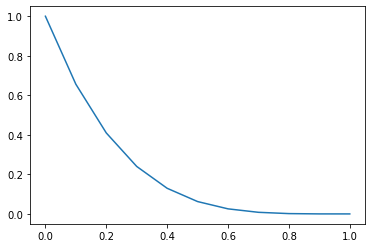

In [11]:
r = 4
xs = np.arange(0,1.01,0.1)
ys = list(map(lambda x: (1-x)**r,xs))
plt.plot(xs,ys);

* The **AND-construction** makes the probability of $d_2$ closer to zero. Meaning, we are reducing the false positives.
* Tweak $r$ such that the the desired $d_2$ will have a very small probability

**OR-Construction**

1. Suppose $H$ consists of $\{h_1, h_2, h_3, ...\}$, we can construct $H'=\{ h'_1, h'_2, h'_3,...\}$, such that $h' = \{ h_1,...,h_b\}$.
2. Now, $h'(x)=h'(y)$ if and only if $h_i(x)=h_i(y)$ for for at least 1 $i$.

What's the sensitivity of $H'$?

$(d_1, d_2, 1-(d_1)^b, 1-(d_2)^b)$

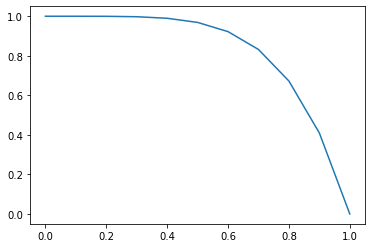

In [10]:
b = 5
xs = np.arange(0,1.01,0.1)
ys = list(map(lambda x: 1-x**b,xs))
plt.plot(xs,ys);

* The **OR-construction** makes the probability of $d_1$ closer to 1. Meaning, we are decreasing the false negatives.
* Tweak $b$ such that the the desired $d_1$ will have a very high probability

### Composing Constructions

The **AND-construction** and the **OR-construction** by themselves can not give us the ideal S-curve that we want. We can compose an **AND-OR construction** as described in the **LSH for MinHash Signature Matrix** example.

In that example, we were able to create a LSH Family with a sensitivity of $(d_1, d_2, 1-(1-(1-d_1)^r)^b, 1-(1-(1-d_2)^r)^b)$

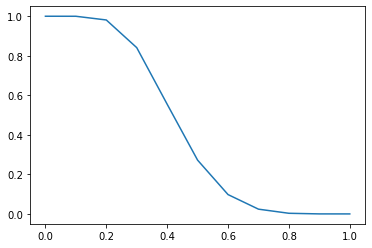

In [15]:
r= 5
b = 10
xs = np.arange(0,1.01,0.1)
ys = list(map(lambda x: 1-(1-(1-x)**r)**b,xs))
plt.plot(xs,ys);

* We can make the S-curve even better by cascading the constructions. However this means more memory usage since we need to construct more hash tables.

### LSH Families for Other Distance Metrics

So far we have constructed several LSH Families from the family of MinHash functions (which approximates the Jaccard distance).

How can we construct a family of hash functions for other distance metrics?

#### Review of Distance Metrics

Definition:

**Examples**

1. Euclidean distance
2. Cosine distance
3. Hamming distance



## References

1. Jure Leskovec , Anand Rajaraman, and Jeffrey D Ullman. *Mining of massive datasets*.Cambridge university press, 3rd edition, 2019. URL http://www.mmds.org/, chapter 3.

2. Jure Leskovec , Anand Rajaraman, and Jeffrey D Ullman, *Finding Similar Items: Locality Sensitive Hashing* [PowerPoint slides]. http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf.